<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/Intraday_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade arch

In [2]:
import warnings

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from arch import arch_model  # pip install arch
from scipy.stats import percentileofscore, probplot
import seaborn as sns
from datetime import datetime, timedelta

In [4]:
warnings.filterwarnings("ignore")

In [5]:
ticker = 'NIFTYBEES.NS'
scale_factor = 10000

window_idx = 60
history_length = 60
forecast_length = 45

arima_order = (5, 1, 5)

garch_p = 1
garch_q = 1
garch_distribution = 'normal'

num_paths = 10000
paths_to_plot = 20

In [6]:
def get_previous_trading_day(ref_date):
    """
    Given a reference date, return the previous trading day.
    This simple logic assumes that weekends are non-trading days.
    For more robust handling (e.g. holidays), consider using a market calendar.
    """
    weekday = ref_date.weekday()
    # Monday: go back to Friday (3 days)
    if weekday == 0:
        return ref_date - timedelta(days=3)
    # Sunday: go back to Friday (2 days)
    elif weekday == 6:
        return ref_date - timedelta(days=2)
    # Saturday: go back to Friday (1 day)
    elif weekday == 5:
        return ref_date - timedelta(days=1)
    else:
        # For Tuesday to Friday, subtract one day.
        return ref_date - timedelta(days=1)


In [7]:
def download_data(ticker):
    # Determine today's date and then compute the previous trading day.
    today = datetime.today().date()
    prev_trading_day = get_previous_trading_day(today)

    # Format start and end dates.
    # Note: When using yfinance, the 'end' date is non-inclusive.
    start_date = prev_trading_day.strftime("%Y-%m-%d")
    end_date = (prev_trading_day + timedelta(days=1)).strftime("%Y-%m-%d")

    print(f"Downloading {ticker} intraday data for {start_date}")

    # Download intraday data with a 1-minute interval.
    data = yf.download(ticker, start=start_date, end=end_date, interval="1m")

    if data.index.tzinfo is None:
        data.index = data.index.tz_localize('UTC')

    data.index = data.index.tz_convert('Asia/Kolkata')

    return data

In [8]:
def calculate_return(data, scale_factor):
    data_ = pd.DataFrame({
        'S' : data['Close'].values.reshape((-1,))
    }, index = data.index)

    data_.eval('log_S = log(S)', inplace = True)
    data_['scaled_return'] = scale_factor * data_['log_S'].diff()
    data_.dropna(inplace = True)

    return data_

In [9]:
def arima_garch(return_data, window_idx, history_length, forecast_length, plot = False, monte_calro_plot = False):
    window_data = return_data.iloc[window_idx - history_length : window_idx]
    return_index = return_data.index

    lags = int(history_length/4)

    if plot:
        # Plot ACF and PACF
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # ACF Plot
        plot_acf(window_data['scaled_return'], ax=axes[0], lags=lags)
        axes[0].set_title(f"{ticker} Log Returns - ACF")

        # PACF Plot
        plot_pacf(window_data['scaled_return'], ax=axes[1], lags=lags, method="ywm")
        axes[1].set_title(f"{ticker} Log Returns - PACF")

        plt.show()

    if plot:
        result = adfuller(window_data['scaled_return'])
        print(f"ADF Statistic: {result[0]}")
        print(f"P-Value: {result[1]}")
        if result[1] < 0.05:
            print("✅ Series is Stationary")
        else:
            print("❌ Series is NOT Stationary")

    model = ARIMA(window_data[['scaled_return']], order=arima_order)
    model_fit = model.fit()
    if plot:
        print(model_fit.summary())

    N = len(return_index)

    # Create a date range for the forecast period (forecast_years from today)
    forecast_index = return_index[window_idx: window_idx + forecast_length]

    forecast_steps = len(forecast_index)

    # Forecast percent log returns using ARIMA.
    forecast_results = model_fit.get_forecast(steps = forecast_steps)
    forecast_mean = forecast_results.predicted_mean
    forecast_ci = forecast_results.conf_int()

    forecast_mean.index = forecast_index
    forecast_ci.index = forecast_index

    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(window_data[['scaled_return']], label='Observed')
        plt.plot(forecast_mean, label='Forecast', color='red')
        plt.fill_between(forecast_ci.index,
                        forecast_ci.iloc[:, 0],
                        forecast_ci.iloc[:, 1],
                        color='pink', alpha=0.3, label='95% CI')
        plt.xlabel('Date')
        plt.ylabel('Scaled Log Return')
        plt.legend()
        plt.show()



    arima_resid = model_fit.resid.dropna()

    if plot:
        # Plot ACF and PACF
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # ACF Plot
        plot_acf(arima_resid**2, ax=axes[0], lags=lags)
        axes[0].set_title(f"{ticker} ARIMA Residue Squared - ACF")

        # PACF Plot
        plot_pacf(arima_resid**2, ax=axes[1], lags=lags, method="ywm")
        axes[1].set_title(f"{ticker} ARIMA Residue Squared - PACF")

        plt.show()

    garch_model = arch_model(arima_resid, vol='Garch', p=garch_p, q=garch_q, dist=garch_distribution)
    garch_fit = garch_model.fit(disp='off')

    if plot:
        print(garch_fit.summary())


    garch_forecast = garch_fit.forecast(horizon=forecast_steps)
    # Use the last available variance forecast.
    forecast_variance = garch_forecast.variance.iloc[-1]
    forecast_volatility = np.sqrt(forecast_variance)
    forecast_volatility.index = forecast_index

    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(forecast_volatility, label='Forecasted Volatility')
        plt.title(f'GARCH Forecasted Volatility for {ticker}\n(Percent Scale)')
        plt.xlabel('Date')
        plt.ylabel('Volatility (%)')
        plt.legend()
        plt.show()

    last_log_price = window_data['log_S'].iloc[-1]

    # IMPORTANT: The ARIMA forecast is in percent; to convert to standard log returns, divide by 100.
    forecast_log_price = last_log_price + np.cumsum(forecast_mean / scale_factor)

    # For the envelope, add/subtract 2 times the forecasted volatility (in percent) then divide by 100.
    forecast_log_price_up = last_log_price + np.cumsum((forecast_mean + 2 * forecast_volatility) / scale_factor)
    forecast_log_price_down = last_log_price + np.cumsum((forecast_mean - 2 * forecast_volatility) / scale_factor)

    # Convert forecasted log prices back to the original price scale.
    forecast_price = np.exp(forecast_log_price)
    forecast_price_up = np.exp(forecast_log_price_up)
    forecast_price_down = np.exp(forecast_log_price_down)

    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(data['Close'], label='Observed Price')
        plt.plot(forecast_index, forecast_price, label='Forecast Price', color='red')
        plt.fill_between(forecast_index,
                       forecast_price_down,
                       forecast_price_up,
                       color='pink', alpha=0.3, label='±2x Volatility Envelope')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

    simulated_paths = pd.DataFrame(index=forecast_index, columns=range(num_paths))

    simulated_paths = pd.DataFrame(index=forecast_index, columns=range(num_paths))

    for path in range(num_paths):
        simulated_log_prices = []
        current_log_price = last_log_price
        for t in range(forecast_length):
            mu = forecast_mean.iloc[t]         # in percent
            sigma = forecast_volatility.iloc[t]  # in percent
            shock = mu + sigma * np.random.randn()
            current_log_price += shock / scale_factor    # convert percent to standard log return
            simulated_log_prices.append(current_log_price)
        simulated_paths[path] = np.exp(simulated_log_prices)

    # For plotting, randomly select a subset of simulation paths.
    np.random.seed(42)  # For reproducibility.
    selected_paths = np.random.choice(simulated_paths.columns, paths_to_plot, replace=False)

    ci_lower_forecast = simulated_paths.quantile(0.025, axis=1)
    first_quartile_forecast = simulated_paths.quantile(0.25, axis=1)
    median_forecast = simulated_paths.quantile(0.5, axis=1)
    third_quartile_forecast = simulated_paths.quantile(0.75, axis=1)
    ci_upper_forecast = simulated_paths.quantile(0.975, axis=1)

    if plot:
        plt.figure(figsize=(10, 4))
        for path in selected_paths:
            plt.plot(simulated_paths.index, simulated_paths[path], lw=1, alpha=0.8,
                    label='MC Path' if path == selected_paths[0] else None)
        plt.plot(data['Close'], label='Observed Price', color='black')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

    if monte_calro_plot:
        plt.figure(figsize=(10, 6))
        # Plot the ARIMA-based forecast price (or any central measure, e.g., the median of the simulations)
        plt.plot(forecast_index, median_forecast, label="Median Monte Carlo Forecast", color='blue', linewidth=2)
        plt.plot(forecast_index, first_quartile_forecast, label="1st Quartile Monte Carlo Forecast", color='red', linestyle = '--')
        plt.plot(forecast_index, third_quartile_forecast, label="3rd Quartile Carlo Forecast", color='green', linestyle = '--')
        plt.plot(forecast_index, ci_lower_forecast, label="2.5 Percentile Monte Carlo Forecast", color='red')
        plt.plot(forecast_index, ci_upper_forecast, label="97.5 Percentile Monte Carlo Forecast", color='green')
        # Fill between the lower and upper percentiles
        plt.fill_between(forecast_index, ci_lower_forecast, ci_upper_forecast, color='gray', alpha=0.3, label="95% Confidence Interval")
        plt.plot(data['Close'], label='Observed Price', color='black')
        plt.title("95% Confidence Interval for Price Forecast (Monte Carlo)")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.show()

    current_price = window_data['S'].iloc[-1]

    final_prices = simulated_paths.iloc[-1]

    simulated_returns = 100 * (final_prices - current_price) / current_price

    confidence_level = 0.95
    alpha = 1 - confidence_level  # 0.05
    var_threshold = np.percentile(simulated_returns, 100 * alpha)  # 5th percentile
    var_threshold_short = np.percentile(simulated_returns, 100 * confidence_level)
    expected_shortfall = simulated_returns[simulated_returns <= var_threshold].mean()
    expected_shortfall_short = simulated_returns[simulated_returns >= var_threshold_short].mean()

    current_price_percentile = percentileofscore(final_prices, current_price)
    prob_profit = 100 - current_price_percentile

    if monte_calro_plot:
        print(f"Current Price :  {current_price}")
        print(f"Value at Risk (95% confidence level): {var_threshold:.2f}%")
        print(f"Expected Shortfall (95% confidence level): {expected_shortfall:.2f}%")
        print(f"Value at Risk Short (95% confidence level): {var_threshold_short:.2f}%")
        print(f"Expected Shortfall Short (95% confidence level): {expected_shortfall_short:.2f}%")
        print(f"Probability of Profit (Final Price > Current Price): {prob_profit:.2f}%")


In [10]:
data = download_data(ticker)
return_data = calculate_return(data, scale_factor)

[*********************100%***********************]  1 of 1 completed


In [11]:
N = len(return_data)


In [12]:
window_idx

60

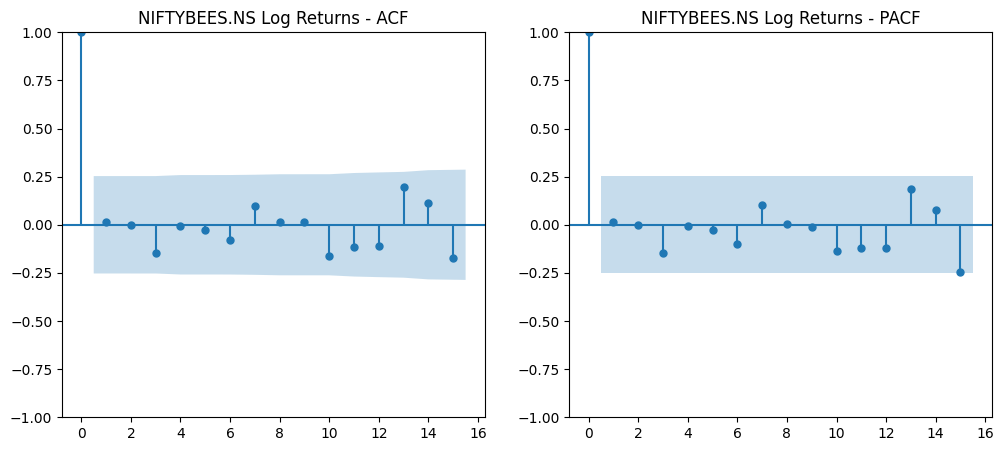

ADF Statistic: -4.740629326865369
P-Value: 7.054372363107218e-05
✅ Series is Stationary
                               SARIMAX Results                                
Dep. Variable:          scaled_return   No. Observations:                   60
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -176.499
Date:                Sat, 15 Feb 2025   AIC                            374.998
Time:                        15:18:09   BIC                            397.851
Sample:                    02-14-2025   HQIC                           383.919
                         - 02-14-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2326      0.351     -3.508      0.000      -1.921      -0.544
ar.L2         -0.9698      0.567     -1.710

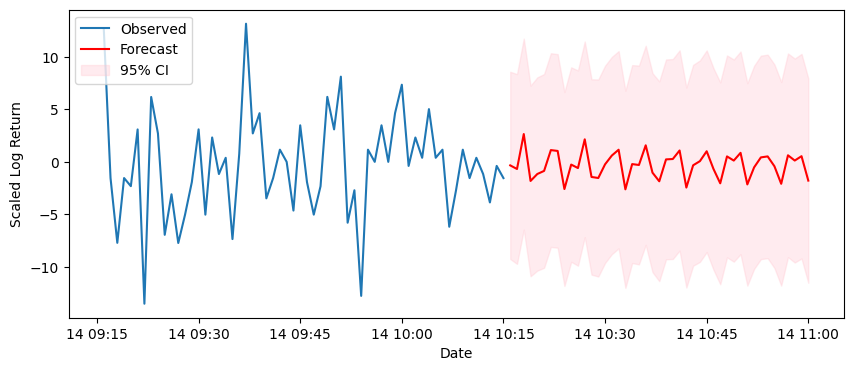

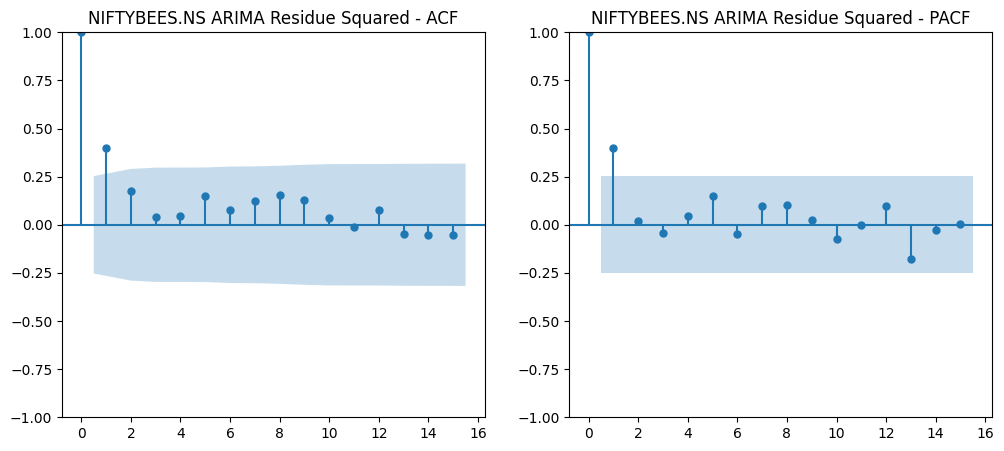

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -177.712
Distribution:                  Normal   AIC:                           363.424
Method:            Maximum Likelihood   BIC:                           371.802
                                        No. Observations:                   60
Date:                Sat, Feb 15 2025   Df Residuals:                       59
Time:                        15:18:10   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0724      0.503      0.144      0.886 [ -0.913,  1.05

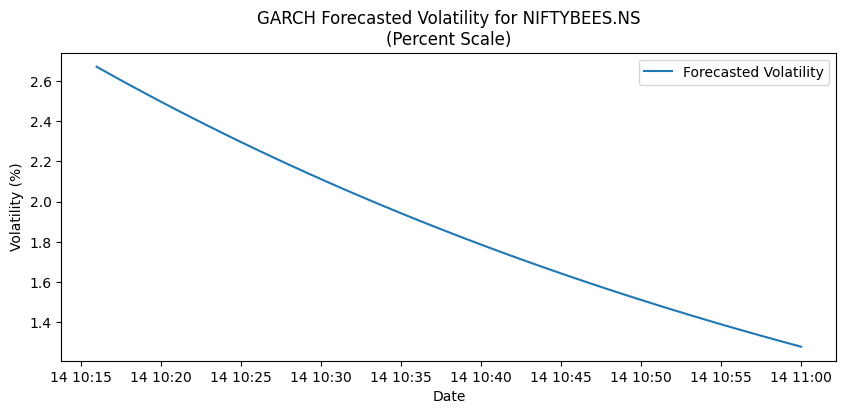

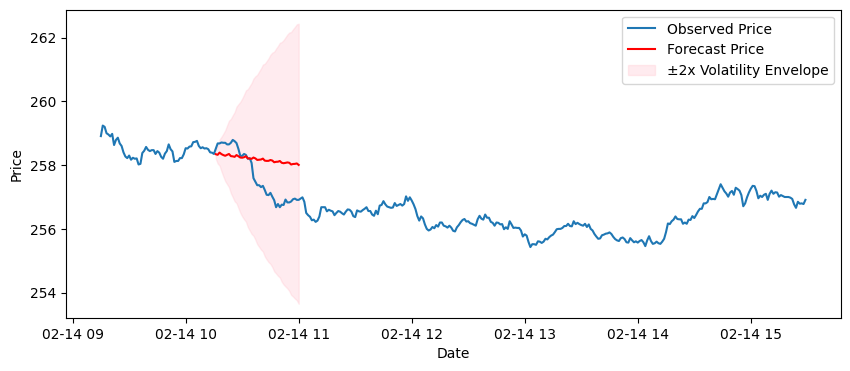

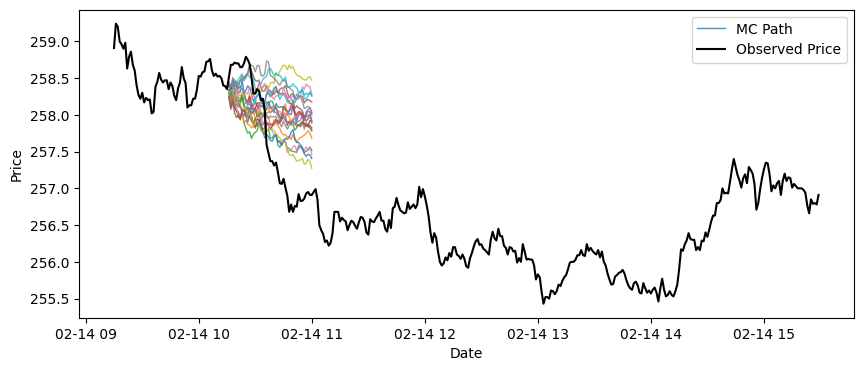

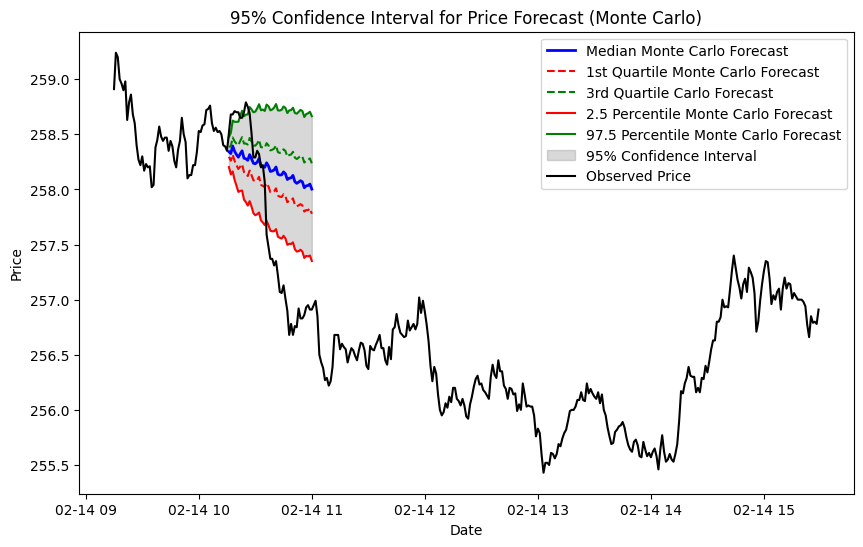

Current Price :  258.3500061035156
Value at Risk (95% confidence level): -0.34%
Expected Shortfall (95% confidence level): -0.40%
Value at Risk Short (95% confidence level): 0.08%
Expected Shortfall Short (95% confidence level): 0.13%
Probability of Profit (Final Price > Current Price): 15.63%


In [13]:
arima_garch(return_data, window_idx, history_length, forecast_length, plot = True, monte_calro_plot = True)